## Abstract

Tenter de prédire à quel personnage de GoT correspond une tirade au hasard, voilà l'objet de ce notebook.

## Résultat

Héals, le volume de donnée est insuffisant pour parvenir à un résultat

In [1]:
# Générique data project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pour la manipulation de fichiers
import os
import glob
from pathlib import Path

# Prépa données
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Deep learning
import tensorflow as tf
from tensorflow.keras.layers import RNN,GRUCell,Dropout,GlobalAveragePooling1D,Dense,Embedding
from tensorflow.keras import Sequential

# Txt mining
import re

# MISC
import warnings
warnings.filterwarnings("ignore")
import swifter
import random

On importe le dataset et on en présente quelques lignes

In [2]:
df =pd.read_csv('game-of-thrones.csv')
df

,Text,Speaker,Episode,Season,Show
0,[First scene opens with three Rangers riding t...,NaN,e1-Winter is Coming,season-01,Game-of-Thrones
1,What d’you expect? They’re savages. One lot s...,WAYMAR ROYCE,e1-Winter is Coming,season-01,Game-of-Thrones
2,I’ve never seen wildlings do a thing like thi...,WILL,e1-Winter is Coming,season-01,Game-of-Thrones
3,How close did you get?,WAYMAR ROYCE,e1-Winter is Coming,season-01,Game-of-Thrones
4,Close as any man would.,WILL,e1-Winter is Coming,season-01,Game-of-Thrones
...,...,...,...,...,...
33193,The Queen in the North! The Queen in the Nort...,ALL,e6,season-08,Game-of-Thrones
33194,ARYA's ship,CUT TO,e6,season-08,Game-of-Thrones
33195,ARYA stands at the prow and the ship sails awa...,NaN,e6,season-08,Game-of-Thrones
33196,Castle Black,CUT TO,e6,season-08,Game-of-Thrones


In [3]:
df = df.dropna()

On se propose d'entrainer un algorithme de sorte qu'il soit capable d'idientifier correctement 6 protagonistes phare de l'oeuvre, choisi pour leur durée de vie dans la série (de façon à maixmiser le nombre d'entrée dans la dataframe):

- Arya Stark
- Jaime Lannister
- Jon Snow
- Daenerys
- Tyrion Lannister
- Cersei Lannister

Il parait pertinent de vérifier le contenu de la variable "Speaker" afin de vérifier les éventuels biais qu'il nous faudra corriger / éviter:

In [4]:
df.Speaker.unique()

array(['WAYMAR ROYCE', 'WILL', 'GARED', 'ROYCE', 'JON',
       'SEPTA MORDANE (to SANSA)', 'SANSA', 'SEPTA MORDANE', 'NED',
       'ROBB', 'JON/ROBB', 'CASSEL', 'CATELYN', 'WILL (muttering)',
       'WILL (whispering)', 'JON (to BRAN)', 'BRAN', 'THEON',
       'ROBB (disgustedly to THEON)', 'BRAN (to JON)', 'JAIME', 'CERSEI',
       'MAESTER LUWIN', 'LUWIN', 'BRAN (looking down)',
       'ARYA (pushing BRAN)', 'ROBERT', 'ARYA', 'TYRION', 'ROS',
       'VISERYS (off camera)', 'VISERYS', 'DAENERYS', 'MAID', 'ILLYRIO',
       'BENJEN', 'TYRION (drinking)', 'SANSA (discomfited)',
       'CERSEI (to CATELYN)', 'A VOICE', 'JORAH', 'KHAL DROGO',
       'THE HOUND', 'Yoren', 'Arya Stark', 'Bran Stark', 'Osha',
       'Rickon Stark', 'Maester Luwin', 'Several Stark Bannermen',
       'Catelyn Stark', 'Robb Stark', 'Marillion', 'Joffrey Baratheon',
       'Sansa Stark', 'Sandor Clegane', 'Jonos Bracken', 'Galbart Glover',
       'Rickard Karstark', 'Theon Greyjoy', 'Greatjon Umber', 'All',
     

Les biais habituels sur ce genre de dataset sont bien présents:
- des noms de personnage en majuscule / minuscule
- des fautes d'orthographes
- différentes appellation d'un même personnage (avec ou sans prénom, nom de jeune fille, avec ou sans surnom,etc...)


Ainsi, pour simplifier, on procède aux opérations suivantes:
- Ramener toutes les entrées en minuscule
- Filtrer avec le plus petit éléments identificateur d'un personnage (par exemple: Arya Stark devient Arya)

In [5]:
df.Speaker = df.Speaker.apply(lambda x : x.lower())

In [6]:
def filtre(x):
    if 'arya' in x:
        return 'arya'
    
    if 'jaime' in x :
        return 'jaime'
    
    if 'jon' in x :
        return 'jon'
    
    if 'daenerys' in x:
        return 'daenerys'
    
    if 'daenarys' in x:
        return 'daenerys'
    
    if 'danaerys' in x:
        return 'daenerys'
    
    if 'deanerys' in x:
        return 'daenerys'
    
    
    if 'tyrion' in x:
        return 'tyrion'
    
    if 'cersei' in x:
        return 'cersei'
    
    if 'cesei' in x:
        return 'cersei'
    
    else:
        return x

In [7]:
df.Speaker = df.Speaker.apply(lambda x : filtre(x))

In [8]:
df.Speaker.unique()

array(['waymar royce', 'will', 'gared', 'royce', 'jon',
       'septa mordane (to sansa)', 'sansa', 'septa mordane', 'ned',
       'robb', 'cassel', 'catelyn', 'will (muttering)',
       'will (whispering)', 'bran', 'theon',
       'robb (disgustedly to theon)', 'jaime', 'cersei', 'maester luwin',
       'luwin', 'bran (looking down)', 'arya', 'robert', 'tyrion', 'ros',
       'viserys (off camera)', 'viserys', 'daenerys', 'maid', 'illyrio',
       'benjen', 'sansa (discomfited)', 'a voice', 'jorah', 'khal drogo',
       'the hound', 'yoren', 'bran stark', 'osha', 'rickon stark',
       'several stark bannermen', 'catelyn stark', 'robb stark',
       'marillion', 'joffrey baratheon', 'sansa stark', 'sandor clegane',
       'galbart glover', 'rickard karstark', 'theon greyjoy', 'all',
       'stark guard', 'lancel lannister', 'tywin lannister',
       'leo lefford', 'addam marbrand', 'kevan lannister',
       'jorah mormont', 'mirri maz duur', 'samwell tarly', 'shae',
       'sam, pyp, 

On produit la dataframe ne contenant que ces personnages

In [9]:
perso = ['arya','jon','jaime','tyrion','cersei','daenerys']
data = df[df.Speaker.isin(perso)].reset_index().drop(['index'],axis = 1)

In [10]:
data

,Text,Speaker,Episode,Season,Show
0,Go on. Father’s watching.,jon,e1-Winter is Coming,season-01,Game-of-Thrones
1,And your mother.,jon,e1-Winter is Coming,season-01,Game-of-Thrones
2,"Don’t think too much, Bran.",jon,e1-Winter is Coming,season-01,Game-of-Thrones
3,"Quick, Bran, faster!",jon,e1-Winter is Coming,season-01,Game-of-Thrones
4,Don’t look away.,jon,e1-Winter is Coming,season-01,Game-of-Thrones
...,...,...,...,...,...
6672,"Ser Bronn of the Blackwater, Lord of Highgard...",tyrion,e6,season-08,Game-of-Thrones
6673,Good. Time to start incurring a new one. We h...,tyrion,e6,season-08,Game-of-Thrones
6674,"Lord Davos, we have an armada to rebuild and ...",tyrion,e6,season-08,Game-of-Thrones
6675,Find the best builders and set them to the task.,tyrion,e6,season-08,Game-of-Thrones


On vérifie que les personnages ont un taux d'occurence similaire dans la dataframe

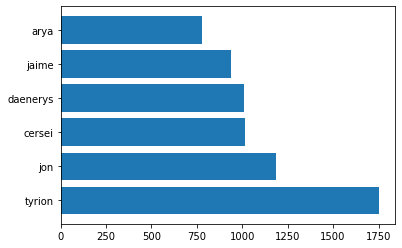

In [11]:
plt.barh(data.Speaker.value_counts().index,data.Speaker.value_counts().values)
plt.show()

Il est à craindre que le volume de donnée soit insuffisant

A partir de cette étape, on met en oeuvre les opérations qui vont nous permettre d'entrainer un modèle RNN

- On associe à chaque personnage un id numérique

In [12]:
 
dictus ={u:i for i,u in enumerate(perso)}

In [13]:
data['id']=data.Speaker.apply(lambda x: dictus[x])

In [14]:
data

,Text,Speaker,Episode,Season,Show,id
0,Go on. Father’s watching.,jon,e1-Winter is Coming,season-01,Game-of-Thrones,1
1,And your mother.,jon,e1-Winter is Coming,season-01,Game-of-Thrones,1
2,"Don’t think too much, Bran.",jon,e1-Winter is Coming,season-01,Game-of-Thrones,1
3,"Quick, Bran, faster!",jon,e1-Winter is Coming,season-01,Game-of-Thrones,1
4,Don’t look away.,jon,e1-Winter is Coming,season-01,Game-of-Thrones,1
...,...,...,...,...,...,...
6672,"Ser Bronn of the Blackwater, Lord of Highgard...",tyrion,e6,season-08,Game-of-Thrones,3
6673,Good. Time to start incurring a new one. We h...,tyrion,e6,season-08,Game-of-Thrones,3
6674,"Lord Davos, we have an armada to rebuild and ...",tyrion,e6,season-08,Game-of-Thrones,3
6675,Find the best builders and set them to the task.,tyrion,e6,season-08,Game-of-Thrones,3


 - On récupère la liste des mots, à partir de laquelle on produit la liste des mots uniques

In [15]:
def filtre_mot(texte):
    r = re.compile(r"\W+")
    return r.split(texte)
                   
word = [element for liste in data.Text.values for element in filtre_mot(liste)]
unik_word = sorted(set(word))
len(unik_word)

6190

- Pour chaque texte de chaque personnage, on associe une liste comprenant chaque mot du texte

In [16]:
data['phrase']=data.Text.apply(lambda x: filtre_mot(x))
data['longueur']=data.phrase.apply(lambda x : len(x))

In [17]:
data

,Text,Speaker,Episode,Season,Show,id,phrase,longueur
0,Go on. Father’s watching.,jon,e1-Winter is Coming,season-01,Game-of-Thrones,1,"[, Go, on, Father, s, watching, ]",7
1,And your mother.,jon,e1-Winter is Coming,season-01,Game-of-Thrones,1,"[, And, your, mother, ]",5
2,"Don’t think too much, Bran.",jon,e1-Winter is Coming,season-01,Game-of-Thrones,1,"[, Don, t, think, too, much, Bran, ]",8
3,"Quick, Bran, faster!",jon,e1-Winter is Coming,season-01,Game-of-Thrones,1,"[, Quick, Bran, faster, ]",5
4,Don’t look away.,jon,e1-Winter is Coming,season-01,Game-of-Thrones,1,"[, Don, t, look, away, ]",6
...,...,...,...,...,...,...,...,...
6672,"Ser Bronn of the Blackwater, Lord of Highgard...",tyrion,e6,season-08,Game-of-Thrones,3,"[, Ser, Bronn, of, the, Blackwater, Lord, of, ...",31
6673,Good. Time to start incurring a new one. We h...,tyrion,e6,season-08,Game-of-Thrones,3,"[, Good, Time, to, start, incurring, a, new, o...",24
6674,"Lord Davos, we have an armada to rebuild and ...",tyrion,e6,season-08,Game-of-Thrones,3,"[, Lord, Davos, we, have, an, armada, to, rebu...",14
6675,Find the best builders and set them to the task.,tyrion,e6,season-08,Game-of-Thrones,3,"[, Find, the, best, builders, and, set, them, ...",12


In [18]:
data.longueur.unique()

array([  7,   5,   8,   6,  29,   9,  23,  32,  26,   4,  67,  10,  20,
        16,   3,  11,  13,  17,  21,  35,  19,  18,  14,  15,  12,  45,
        22,  77,  28,  41,  48,  82,  59,  25,  50,  68,  51,  27,  33,
        40,  97,  72,  37,  36,  83,  39,  49,  71,  56,  84,  54,  24,
        38,  31,  57,  92,  42,  60,  30,  86, 184,  43,  76, 159,  52,
        47,  46,  44,  34,  65,  66,  78,  62, 106,  63,  89,  79,  64,
        74,  53,  73,  58,  69,   2,  91, 110,  81, 151, 122, 242,  80,
       116,  90, 199,  61, 157,  55, 145,  75,  99,  88,  70, 101, 118,
       136, 175, 108, 109, 105,  87, 107], dtype=int64)

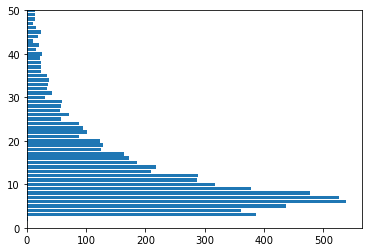

In [19]:
plt.barh(data.longueur.value_counts().index,data.longueur.value_counts().values)
plt.ylim([0,50])
plt.show()

Il nous faut choisir à présent une longueur unique pour nos données d'entrainement. Il faut trouver un compromis entre le nombre minimal de mot requis pour maximiser nos chance de différenciation versus le volume de donnée résiduel sans altération. On postule que 10 élément par liste est un nombre suffisant pour permettre un  bon entrainement et qu'il maximise el nombre de donnée restante.

In [20]:
taille_seq = 10

- On transforme chaque liste de mot en séquence d'entier, sur la base des mots uniques précédemment obtenus

In [21]:
tokenizer_word = tf.keras.preprocessing.text.Tokenizer(num_words=len(unik_word))
tokenizer_word.fit_on_texts(data.phrase)

X = tokenizer_word.texts_to_sequences(data.phrase)

- On fait en sorte que toutes les listes aient la même longueur

In [22]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=taille_seq, padding='post', truncating='post')

In [23]:
X_train_top,X_test_top,y_train_top,y_test_top = train_test_split(X,data.id,test_size = 0.15,random_state = 1234,shuffle = True)

In [24]:
X_train_top = np.asarray(X_train_top)
X_test_top = np.asarray(X_test_top)
y_train_top = np.asarray(y_train_top)
y_test_top = np.asarray(y_test_top)

print(f'shape of X_train_top : {X_train_top.shape}')
print(f'shape of X_test_top : {X_test_top.shape}')
print(f'shape of y_train_top : {y_train_top.shape}')
print(f'shape of y_test_top : {y_test_top.shape}')

shape of X_train_top : (5675, 10)
shape of X_test_top : (1002, 10)
shape of y_train_top : (5675,)
shape of y_test_top : (1002,)


In [25]:
word2idx = tokenizer_word.word_index
idx2word = tokenizer_word.index_word
vocab_word_size = tokenizer_word.num_words

In [26]:
model = tf.keras.Sequential()

model.add(Embedding(vocab_word_size+1,256,input_length=taille_seq))
model.add(RNN(GRUCell(256),return_sequences = False))
model.add(Dropout(0.4))

model.add(Dense(256,'relu'))

model.add(Dropout(0.3))

model.add(Dense(6,'softmax'))

epok = 15

opt = tf.keras.optimizers.Adam(learning_rate=0.007)

model.compile(loss = 'sparse_categorical_crossentropy',optimizer ='adam',metrics =["accuracy"])

training_history = model.fit(X_train_top,y_train_top,validation_data=(X_test_top,y_test_top) ,epochs = epok, batch_size = 128)

Epoch 1/15
45/45 [==============================] - 5s 59ms/step - loss: 1.7586 - accuracy: 0.2536 - val_loss: 1.7358 - val_accuracy: 0.2625
Epoch 2/15
45/45 [==============================] - 2s 50ms/step - loss: 1.6886 - accuracy: 0.2902 - val_loss: 1.6925 - val_accuracy: 0.2764
Epoch 3/15
45/45 [==============================] - 2s 47ms/step - loss: 1.5188 - accuracy: 0.3686 - val_loss: 1.6565 - val_accuracy: 0.3234
Epoch 4/15
45/45 [==============================] - 2s 47ms/step - loss: 1.3000 - accuracy: 0.4952 - val_loss: 1.7027 - val_accuracy: 0.3393
Epoch 5/15
45/45 [==============================] - 2s 48ms/step - loss: 1.0864 - accuracy: 0.5893 - val_loss: 1.8014 - val_accuracy: 0.3583
Epoch 6/15
45/45 [==============================] - 2s 48ms/step - loss: 0.9167 - accuracy: 0.6601 - val_loss: 1.9421 - val_accuracy: 0.3343
Epoch 7/15
45/45 [==============================] - 2s 47ms/step - loss: 0.8054 - accuracy: 0.6989 - val_loss: 2.1219 - val_accuracy: 0.3253
Epoch 8/15
45

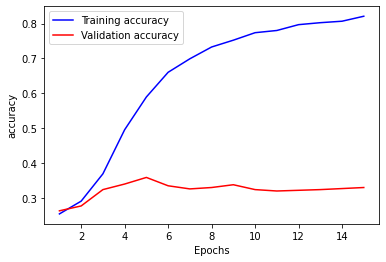

In [27]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.plot(np.arange(1,epok +1,1),training_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(np.arange(1,epok +1,1),training_history.history['val_accuracy'], label='Validation accuracy', color='red')

plt.legend()

plt.show()

In [28]:
# On réalise une prédiction avec le modèle
y_pred = model.predict(X_test_top)
y_pred_propre = y_pred.argmax(axis=-1)

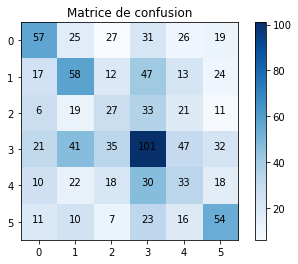

In [29]:
cnf_matrix = confusion_matrix(y_test_top,y_pred_propre)

classes = range(0,6)

plt.figure()
plt.imshow(cnf_matrix,interpolation ='nearest',cmap = 'Blues')
plt.title('Matrice de confusion')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        plt.text(i,j,cnf_matrix[i,j],horizontalalignment ='center')
        
plt.show()

Comme on pouvait s'y attendre, il n'y a pas assez de donnée
































